# DIC-TA,DIC - (TA-DIC) 

In [11]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import utils as ut
import lom


%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater

    region

Text(0.5, 0.98, 'colours assigned')

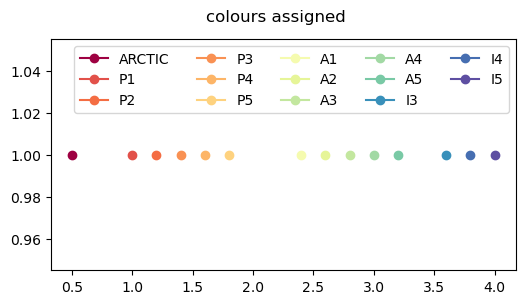

In [12]:
regs = ['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5']

regdict = {'ARCTIC' : {'number' : 0.5},
           'P1' : {'number': 1.0},
          'P2' : {'number': 1.2},
           'P3' : {'number': 1.4},
           'P4' : {'number': 1.6},
           'P5' : {'number': 1.8},
            'A1' : {'number': 2.4},
          'A2' : {'number': 2.6},
           'A3' : {'number': 2.8},
           'A4' : {'number': 3},
           'A5' : {'number': 3.2},
           'I3' : {'number': 3.6},
           'I4' : {'number': 3.8},
           'I5' : {'number': 4},
           
          }
    
tics = []
tcm = 'Spectral'
tmask = nc.Dataset('/gpfs/data/greenocean/software/resources/breakdown/clq_basin_masks_ORCA.nc')

maskno = np.zeros([149,182])
for i in range(0, len(regs)):
    maskno[tmask[regs[i]][:] == 1] = regdict[regs[i]]['number']
    tics.append(regdict[regs[i]]['number'])
maskno[maskno == 0] = np.nan


# w = plt.pcolor(maskno, cmap = tcm, vmin = 0.5, vmax = 4)
# cbar = plt.colorbar(w, ticks=tics)
# t = cbar.ax.set_yticklabels(['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5'], fontsize = 9)
# plt.suptitle('ocean regions, subdivided')

fact = 0.2
fig = plt.figure(figsize=(30*fact,15*fact))
import matplotlib
cmap = matplotlib.cm.get_cmap('Spectral')
norm = matplotlib.colors.Normalize(vmin=0.5, vmax=4)
for i in range(0,len(regs)):
    rgba = cmap(norm(regdict[regs[i]]['number']))
    plt.plot(regdict[regs[i]]['number'], 1, marker = 'o', color = rgba, label = regs[i])
    regdict[regs[i]]['colour'] = rgba
plt.legend(ncol = 5, fontsize = 10)
plt.suptitle('colours assigned')

    (make_yearlist) read model data(1)

In [13]:
# import glob

# def make_yearlist(yrst, yrend, dtype, tr, baseDir):
#     yrs = np.arange(yrst,yrend+1,1)
#     ylist = []
#     for i in range(0,len(yrs)):
#         ty = f'{baseDir}/{tr}/ORCA2_1m_{yrs[i]}*{dtype}*.nc'
#         t2 = glob.glob(ty)
#         #print(t2)
#         ylist.append(t2[0])
#     return ylist

# baseDir = '/gpfs/data/greenocean/software/runs/'
# tr = 'TOM12_TJ_GEA0'
# yrst = 1990
# yrend = 2020
# dtype = 'ptrc'
# tylist = make_yearlist(yrst, yrend, dtype, tr, baseDir)
# tdat_GEA0 = xr.open_mfdataset(tylist)


# tr = 'TOM12_DW_GA01'
# yrst = 1990
# yrend = 2020
# dtype = 'ptrc'
# tylist = make_yearlist(yrst, yrend, dtype, tr, baseDir)
# tdat_GA01 = xr.open_mfdataset(tylist)


# tr = 'TOM12_DW_WE43'
# yrst = 1990
# yrend = 2020
# dtype = 'ptrc'
# tylist = make_yearlist(yrst, yrend, dtype, tr, baseDir)
# tdat_WE43 = xr.open_mfdataset(tylist)

    mesh_mask

In [14]:
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:] # area of grid cells
csize_broad = np.zeros([31,149,182])
for i in range(0,31):
    csize_broad[i,:,:] = tmesh['csize'].values
cvol = csize_broad * tmesh['e3t_0'][0,:,:,:] * tmesh['tmask'][0,:,:,:]

In [15]:
tmesh['maskno'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:] # area of grid cells
maskno_broad = np.zeros([31,149,182])
for i in range(0,31):
    csize_broad[i,:,:] = tmesh['maskno'].values
# cvol = csize_broad * tmesh['e3t_0'][0,:,:,:] * tmesh['tmask'][0,:,:,:]

    region

In [16]:
regs_g = regs.copy()
regs_g.append('GLOBAL')
print(regs_g)

['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5', 'GLOBAL']


In [46]:
extracthorse = True
if extracthorse:
    yst = 2015; yen = 2020; 
    modlist = ['TOM12_TJ_GEA0']     # 'TOM12_DW_GA01','TOM12_DW_WE43']


    for modnam in modlist:
        dtype = 'ptrc_T'; #modnam = modlist[r]
        fnam = f'./EXTRACTED/MLD/MLD_{modnam}_{yst}_{yen}.nc'
        print(fnam)

        ylist = ut.make_yearlist(yst, yen, dtype, modnam)
        tdat = xr.open_mfdataset(ylist)

        DIC_ts = tdat.DIC.isel(deptht=0).weighted(tmesh['csize']).mean(dim = ['x','y']) #surface DIC
        TA_ts = tdat.Alkalini.isel(deptht=0).weighted(tmesh['csize']).mean(dim = ['x','y'])

        tDIC = np.zeros([34,30])
        DIC_ts = tdat.DIC.isel(deptht=0).values
        for r in range(0,len(regs)):
            csize_copy = np.copy(csize_broad)
            csize_copy[maskno_broad != regdict[regs[r]]['number']] = 0
            for i in range(0,30):
                tDIC[r,i] = np.ma.average(DIC_ts[i,:,:], weights = csize_copy[0,:,:])
        
        
        ### get the global one
        
        data_vars = {'DIC':(['region', 'DIC'], tDIC,
                                 {'units': 'model'}),
                    # 'mldr10_1':(['region', 'month'], mldr10_1,
                    #              {'units': 'm'}),             
                    }

        coords = {'region': (['region'], regs_g),\
                 'tDIC': (['DIC'], np.arange(1,13,1))}

        # define global attributes
        attrs = {'made in':'AnalysisRobot/Tester_multimodel_MLD.ipynb',
                }

        # create dataset
        ds = xr.Dataset(data_vars=data_vars,
                        coords=coords,
                        attrs=attrs)
        ds.to_netcdf(fnam)

./EXTRACTED/MLD/MLD_TOM12_TJ_GEA0_2015_2020.nc


type: 'DIC' has more than 1-dimension and the same name as one of its dimensions ('region', 'DIC'). xarray disallows such variables because they conflict with the coordinates used to label dimensions.

    load data from EXTRACTED/MLD

In [42]:
print(tdat.head(5))

<xarray.Dataset>
Dimensions:               (y: 5, x: 5, deptht: 5, time_counter: 5,
                           axis_nbounds: 2)
Coordinates:
    nav_lat               (y, x) float32 dask.array<chunksize=(5, 5), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(5, 5), meta=np.ndarray>
  * deptht                (deptht) float32 5.0 15.0 25.0 35.01 45.01
    time_centered         (time_counter) object dask.array<chunksize=(5,), meta=np.ndarray>
  * time_counter          (time_counter) object 1990-01-16 12:00:00 ... 1990-...
Dimensions without coordinates: y, x, axis_nbounds
Data variables: (12/34)
    deptht_bounds         (time_counter, deptht, axis_nbounds) float32 dask.array<chunksize=(5, 5, 2), meta=np.ndarray>
    Alkalini              (time_counter, deptht, y, x) float32 dask.array<chunksize=(5, 5, 5, 5), meta=np.ndarray>
    time_centered_bounds  (time_counter, axis_nbounds) object dask.array<chunksize=(5, 2), meta=np.ndarray>
    time_counter_bounds  

In [39]:
DIC_ts_GEA0 = tdat_GEA0.DIC.isel(deptht=0).weighted(tmesh['csize']).mean(dim = ['x','y']) #surface DIC
TA_ts_GEA0 = tdat_GEA0.Alkalini.isel(deptht=0).weighted(tmesh['csize']).mean(dim = ['x','y'])

type: 'Dataset' object has no attribute 'DIC'

    weighted mean DIC

In [18]:
# ## weighted mean DIC


# DIC_ts_GA01 = tdat_GA01.DIC.isel(deptht=0).weighted(tmesh['csize']).mean(dim = ['x','y']) #surface DIC
# TA_ts_GA01 = tdat_GA01.Alkalini.isel(deptht=0).weighted(tmesh['csize']).mean(dim = ['x','y'])

# DIC_ts_WE43 = tdat_WE43.DIC.isel(deptht=0).weighted(tmesh['csize']).mean(dim = ['x','y']) #surface DIC
# TA_ts_WE43 = tdat_WE43.Alkalini.isel(deptht=0).weighted(tmesh['csize']).mean(dim = ['x','y'])

    try plot

In [19]:
# # TA vs. DIC

# plt.plot(DIC_ts_GEA0*1e6, TA_ts_GEA0*1e6, label = 'TOM12_DW_WE43')
# plt.legend()
# plt.title('1990-2020 Surface TA vs. DIC umol/L')